## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [26]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [27]:
train, test = keras.datasets.cifar10.load_data()

In [28]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [29]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [30]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64], kernel_regularizer=l2(1e-4)):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=kernel_regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [31]:

"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 2048 # 256
MOMENTUM = 0.95
REGULARIZERS = {
    'l1 (0.01)': l1(1e-2),
    'l1 (0.0001)': l1(1e-4),
    'l2 (0.01)': l2(1e-2),
    'l2 (0.0001)': l2(1e-4),
    'l1_l2 (0.01)': l1_l2(1e-2),
    'l1_l2 (0.0001)': l1_l2(1e-4),
}

In [33]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for key in REGULARIZERS.keys():
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with %s" % (key))
    model = build_mlp(input_shape=x_train.shape[1:], kernel_regularizer=REGULARIZERS[key])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-%s" % str(key)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with l1 (0.01)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 69us/step - loss: 4.2358 - acc: 0.1354 - val_loss: 4.1873 - val_acc: 0.1850
Epoch 2/50
50000/50000 [==============================] - 3s 60us/step - loss: 4.1472 - acc: 0.1913 - val_loss: 4.1039 - val_acc: 0.2124
Epoch 3/50
50000/50000 [==============================] - 3s 62us/step - loss: 4.0666 - acc: 0.2263 - val_loss: 4.0270 - val_acc: 0.2514
Epoch 4/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.9956 - acc: 0.2631 - val_loss: 3.9641 - val_acc: 0.2764
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 3.9396 - acc: 0.2840 - val_loss: 3.9157 - val_acc: 0.2924
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.8964 - acc: 0.3054 - val_loss: 3.8778 - val_acc: 0.3119
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.8607 - acc: 0.3187 - val_loss: 3.8469 - val_acc

50000/50000 [==============================] - 3s 64us/step - loss: 9.3403 - acc: 0.2022 - val_loss: 9.2281 - val_acc: 0.2379
Epoch 3/50
50000/50000 [==============================] - 3s 62us/step - loss: 9.1294 - acc: 0.2508 - val_loss: 9.0233 - val_acc: 0.2617
Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 8.9318 - acc: 0.2746 - val_loss: 8.8348 - val_acc: 0.2898
Epoch 5/50
50000/50000 [==============================] - 3s 64us/step - loss: 8.7499 - acc: 0.2937 - val_loss: 8.6612 - val_acc: 0.3071
Epoch 6/50
50000/50000 [==============================] - 3s 59us/step - loss: 8.5822 - acc: 0.3100 - val_loss: 8.5003 - val_acc: 0.3122
Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 8.4263 - acc: 0.3197 - val_loss: 8.3498 - val_acc: 0.3229
Epoch 8/50
50000/50000 [==============================] - 3s 62us/step - loss: 8.2792 - acc: 0.3291 - val_loss: 8.2066 - val_acc: 0.3375
Epoch 9/50
50000/50000 [============================

Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.0995 - acc: 0.2934 - val_loss: 2.0727 - val_acc: 0.2995
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.0463 - acc: 0.3086 - val_loss: 2.0278 - val_acc: 0.3089
Epoch 6/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.0061 - acc: 0.3211 - val_loss: 1.9946 - val_acc: 0.3223
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.9768 - acc: 0.3319 - val_loss: 1.9699 - val_acc: 0.3337
Epoch 8/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.9540 - acc: 0.3406 - val_loss: 1.9495 - val_acc: 0.3383
Epoch 9/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9356 - acc: 0.3463 - val_loss: 1.9325 - val_acc: 0.3467
Epoch 10/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9197 - acc: 0.3536 - val_loss: 1.9176 - val_acc: 0.3497
Epoch 11/50
50000/50000 [===============

50000/50000 [==============================] - 3s 67us/step - loss: 73.5732 - acc: 0.2447 - val_loss: 61.0025 - val_acc: 0.2517
Epoch 6/50
50000/50000 [==============================] - 4s 80us/step - loss: 51.5694 - acc: 0.2489 - val_loss: 41.8454 - val_acc: 0.2485
Epoch 7/50
50000/50000 [==============================] - 4s 80us/step - loss: 34.9193 - acc: 0.2491 - val_loss: 28.0286 - val_acc: 0.2456
Epoch 8/50
50000/50000 [==============================] - 4s 75us/step - loss: 23.5997 - acc: 0.2537 - val_loss: 19.5261 - val_acc: 0.2537
Epoch 9/50
50000/50000 [==============================] - 3s 67us/step - loss: 17.5137 - acc: 0.2308 - val_loss: 15.9300 - val_acc: 0.1293
Epoch 10/50
50000/50000 [==============================] - 3s 65us/step - loss: 14.7897 - acc: 0.1045 - val_loss: 13.6435 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 4s 72us/step - loss: 12.8374 - acc: 0.1000 - val_loss: 11.9928 - val_acc: 0.1000
Epoch 12/50
50000/50000 [===========

50000/50000 [==============================] - 3s 60us/step - loss: 10.3969 - acc: 0.2921 - val_loss: 10.2909 - val_acc: 0.3042
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 10.1951 - acc: 0.3094 - val_loss: 10.0965 - val_acc: 0.3074
Epoch 8/50
50000/50000 [==============================] - 3s 63us/step - loss: 10.0041 - acc: 0.3184 - val_loss: 9.9099 - val_acc: 0.3254
Epoch 9/50
50000/50000 [==============================] - 3s 67us/step - loss: 9.8211 - acc: 0.3258 - val_loss: 9.7316 - val_acc: 0.3290
Epoch 10/50
50000/50000 [==============================] - 3s 62us/step - loss: 9.6450 - acc: 0.3322 - val_loss: 9.5589 - val_acc: 0.3373
Epoch 11/50
50000/50000 [==============================] - 3s 60us/step - loss: 9.4747 - acc: 0.3382 - val_loss: 9.3917 - val_acc: 0.3399
Epoch 12/50
50000/50000 [==============================] - 3s 63us/step - loss: 9.3093 - acc: 0.3432 - val_loss: 9.2290 - val_acc: 0.3418
Epoch 13/50
50000/50000 [===================

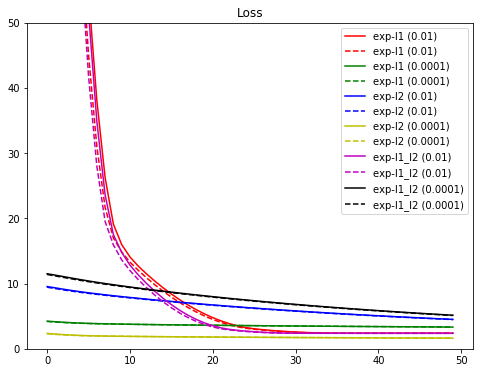

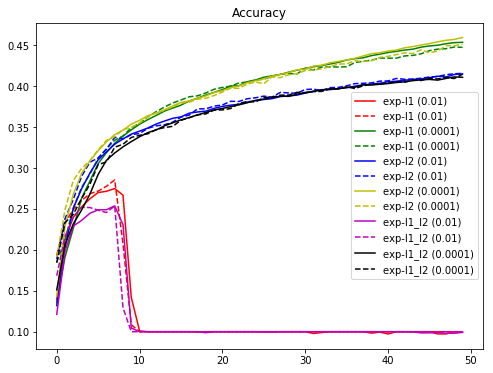

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 50])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()